In [244]:
import math
import numpy as np

import torch
import torch.nn as nn
from torch.nn import LayerNorm
from torch import optim
from torch.utils.data import random_split
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, Subset

from einops import rearrange

import matplotlib.pyplot as plt

import favit
import utils
import train

In [2]:
print(torch.cuda.is_available())

True


In [242]:
class CustomDataset(Dataset):
  def __init__(self, filepath) -> None:
     self.data = np.load(filepath)
     self.data = self.data[:,:,:,:]
     print(self.data.shape)

  def __len__(self):
    return (self.data.shape[0] - 1) * self.data.shape[-1]

  def __getitem__(self, index):
    seq_id = index // (self.data.shape[0] - 1)
    item_id = index % (self.data.shape[0] - 1)
    image = np.expand_dims(self.data[item_id,:,:,seq_id], axis=0)
    target = np.expand_dims(self.data[item_id+1,:,:,seq_id], axis=0)
    return image, target

In [243]:
dataset = CustomDataset('data/fno_ns_Re1000_N1200_T20.npy')
print(len(dataset))

(20, 64, 64, 1200)
22800


In [245]:
n = len(dataset)
train_size = int(0.75 * n)
test_size = n - train_size
train_set = Subset(dataset, range(0, train_size))
test_set = Subset(dataset, range(train_size, n))
print('Train set length:', len(train_set))
print('Test set length:', len(test_set))

Train set length: 17100
Test set length: 5700


In [246]:
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = DataLoader(test_set, batch_size=64)

In [79]:
model = favit.VisionTransformerFFT(ch=1, img_size=64, patch_size=16, stride=4, emb_dim=512, dropout=0.2, n_layers=6)
print(model)
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Number of parameters:', total_params)

VisionTransformerFFT(
  (patch_embedding): PatchEncoding(
    (conv): Sequential(
      (0): Conv2d(1, 256, kernel_size=(8, 8), stride=(4, 4))
      (1): GELU(approximate='none')
      (2): Conv2d(256, 512, kernel_size=(2, 2), stride=(2, 2))
      (3): Flatten(start_dim=-2, end_dim=-1)
    )
  )
  (layers): ModuleList(
    (0-5): 6 x Sequential(
      (0): TransformerEncoderFFT(
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
        )
        (q): Linear(in_features=512, out_features=512, bias=True)
        (k): Linear(in_features=512, out_features=512, bias=True)
        (v): Linear(in_features=512, out_features=512, bias=True)
        (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (feedforward): Sequential(
          (0): Linear(in_features=512, out_features=256, bias=True)
          (1): GELU(appr

In [74]:
import importlib
importlib.reload(utils)
importlib.reload(favit)

<module 'favit' from 'c:\\Mark\\Uni Stuttgart\\Semester3\\thesis\\FAViT\\favit.py'>

In [ ]:
train_losses, test_losses = train.train(
    model, 
    train_loader, 
    test_loader, 
    loss_function=utils.HighFrequencyLPLoss(weight_hf=0.2, weight_lp=0.8), 
    num_epochs=150, 
    early_stop=utils.EarlyStopping(patience=150, delta=0),
    lr=0.0005)
torch.save(model.state_dict(), 'best.pt')

Start training...
batch: 0
batch: 1
batch: 2
batch: 3
batch: 4
batch: 5
batch: 6
batch: 7
batch: 8
batch: 9
batch: 10
batch: 11
batch: 12
batch: 13
batch: 14
batch: 15
batch: 16
batch: 17
batch: 18
batch: 19
batch: 20
batch: 21
batch: 22
batch: 23
batch: 24
batch: 25
batch: 26
batch: 27
batch: 28
batch: 29
batch: 30
batch: 31
batch: 32
batch: 33
batch: 34
batch: 35
batch: 36
batch: 37
batch: 38
batch: 39
batch: 40
batch: 41
batch: 42
Epoch 1 training loss: 1.3557852894760842
Epoch 1 testing loss: 0.8590020855267843
batch: 0
batch: 1
batch: 2
batch: 3
batch: 4
batch: 5
batch: 6
batch: 7
batch: 8
batch: 9
batch: 10
batch: 11
batch: 12
batch: 13
batch: 14
batch: 15
batch: 16
batch: 17
batch: 18
batch: 19
batch: 20
batch: 21
batch: 22
batch: 23
batch: 24
batch: 25
batch: 26
batch: 27
batch: 28
batch: 29
batch: 30
batch: 31
batch: 32
batch: 33
batch: 34
batch: 35
batch: 36
batch: 37
batch: 38
batch: 39
batch: 40
batch: 41
batch: 42
Epoch 2 training loss: 0.7627172885939132
Epoch 2 testing l

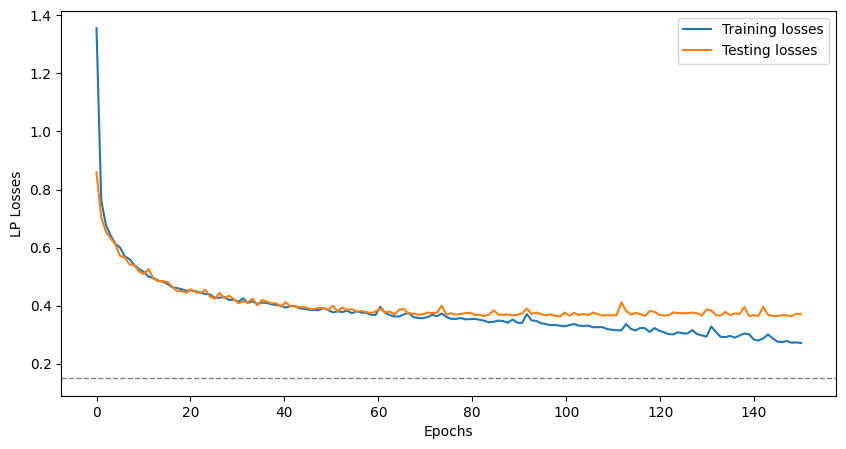

In [81]:
epochs = 150
train_scale = np.linspace(0, epochs, epochs)
test_scale = np.linspace(0, epochs, epochs)

plt.figure(figsize=(10, 5))
plt.plot(train_scale, train_losses, label="Training losses")
plt.plot(test_scale, test_losses, label="Testing losses")
plt.axhline(y=0.15, color='gray', linestyle='--', linewidth=1)
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("LP Losses")
plt.savefig('lp_losses.png')
plt.show()

## Evaluate

In [240]:
model = favit.VisionTransformerFFT(ch=1, img_size=64, patch_size=8, stride=2, emb_dim=512, dropout=0.2, n_layers=6)
model.load_state_dict(torch.load('models/fft_block_8patch_4stride/best_2.pt', weights_only=True))
model.eval()
model.to('cpu')

VisionTransformerFFT(
  (patch_embedding): PatchEncoding(
    (conv): Sequential(
      (0): Conv2d(1, 256, kernel_size=(4, 4), stride=(2, 2))
      (1): GELU(approximate='none')
      (2): Conv2d(256, 512, kernel_size=(2, 2), stride=(2, 2))
      (3): Flatten(start_dim=-2, end_dim=-1)
    )
  )
  (layers): ModuleList(
    (0-5): 6 x Sequential(
      (0): TransformerEncoderFFT(
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
        )
        (q): Linear(in_features=512, out_features=512, bias=True)
        (k): Linear(in_features=512, out_features=512, bias=True)
        (v): Linear(in_features=512, out_features=512, bias=True)
        (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (feedforward): Sequential(
          (0): Linear(in_features=512, out_features=256, bias=True)
          (1): GELU(appr

In [10]:
import eval

In [11]:
import importlib
importlib.reload(eval)

<module 'eval' from 'c:\\Mark\\Uni Stuttgart\\Semester3\\thesis\\FAViT\\eval.py'>

In [100]:
print(model(torch.Tensor(np.ones([1,1,64,64]))).shape)
print(model(torch.Tensor(np.ones([1,1,256,256]))).shape)

torch.Size([1, 1, 64, 64])
torch.Size([1, 1, 256, 256])


In [168]:
input, target = next(iter(test_loader))
input = np.expand_dims(input[0], axis=0)
target = np.array(target[0][0])

In [169]:
pred = model(torch.Tensor(input)).detach().numpy()[0,0,:,:]
ground = target
print(pred.shape)
print(ground.shape)

(64, 64)
(64, 64)


In [231]:
print('RMSE', eval.rmse(pred, ground))
print('Normalized RMSE', eval.normalized_rmse(pred, ground))
print('Max error', eval.max_error(pred, ground))
print('Boundary RMSE', eval.rmse_boundaries(pred, ground))
print('Conserved variables', eval.conserved_variables_error(pred, ground))
print('RMSE in Fourier', eval.rmse_fourier(pred, ground))
print('Temporal sensitivity', eval.temporal_sensitivity_error(pred, ground))

RMSE 0.11597351
Normalized RMSE 0.081285305
Max error 0.36171907
Boundary RMSE 0.112315744
Conserved variables 4.4141235
RMSE in Fourier 4.292117272021226
Temporal sensitivity 0.019252686


In [209]:
eval.compare_high_frequencies(pred, ground)

{'LH_similarity': 0.5244960060271506,
 'HL_similarity': 0.5798112491473622,
 'HH_similarity': 0.05776254512374888}

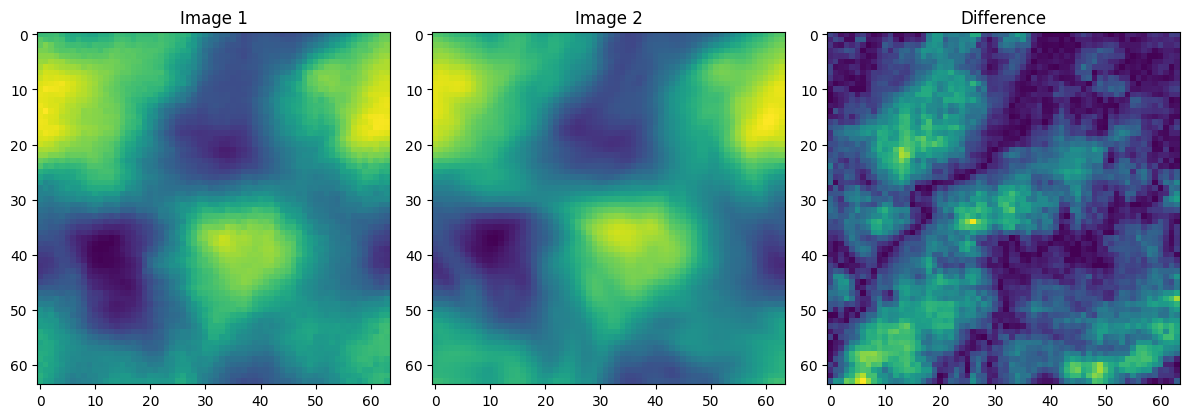

In [210]:
eval.compare_images(pred, ground)

In [139]:
import importlib
importlib.reload(favit)
importlib.reload(eval)

<module 'eval' from 'c:\\Mark\\Uni Stuttgart\\Semester3\\thesis\\FAViT\\eval.py'>

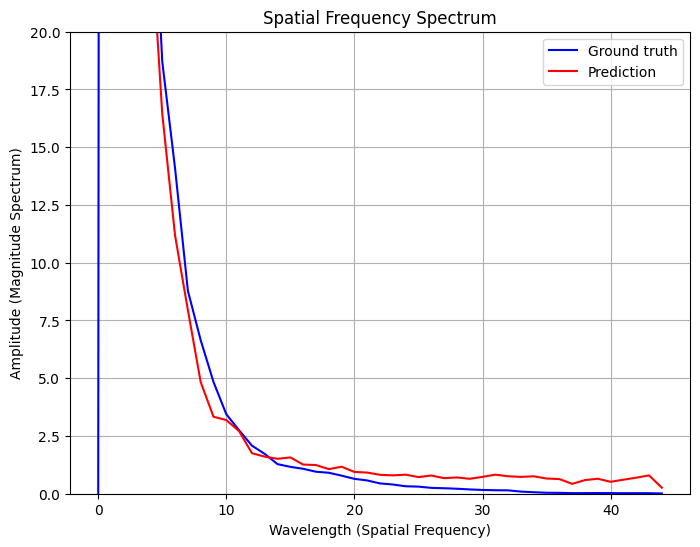

In [195]:
eval.plot_radial_frequency_spectrum(ground, pred, [0,20])

In [241]:
rmses = 0
nrmses = 0
maxerrors = 0
brmses = 0
convars = 0
frmses = 0
tss = 0
lhs = 0
hls = 0
hhs = 0

for batch in test_loader:
    inputs, targets = batch
    for x, y in zip(inputs, targets):
        y_pred = model(torch.Tensor(np.expand_dims(x, axis=0))).detach().numpy()[0,0,:,:]
        y = y.numpy()[0, :, :]
        rmses += eval.rmse(y_pred, y)
        nrmses += eval.normalized_rmse(y_pred, y)
        maxerrors += eval.max_error(y_pred, y)
        brmses += eval.rmse_boundaries(y_pred, y)
        convars += eval.conserved_variables_error(y_pred, y)
        frmses += eval.rmse_fourier(y_pred, y)
        tss += eval.temporal_sensitivity_error(y_pred, y)
        ssim = eval.compare_high_frequencies(y_pred, y)
        lhs += ssim['LH_similarity']
        hls += ssim['HL_similarity']
        hhs += ssim['HH_similarity']
        
n = len(test_loader) * 64

print('RMSE', rmses / n)
print('Normalized RMSE', nrmses / n)
print('Max error', maxerrors / n)
print('Boundary RMSE', brmses / n)
print('Conserved variables', convars / n)
print('RMSE in Fourier', frmses / n)
print('Temporal sensitivity', tss / n)
print('LH similarity', lhs / n)
print('HL similarity', hls / n)
print('HH similarity', hhs / n)

RMSE 0.08185129065144187
Normalized RMSE 0.04876560017000884
Max error 0.2923995320219547
Boundary RMSE 0.08842440805165097
Conserved variables 46.269923785328864
RMSE in Fourier 4.010095051432507
Temporal sensitivity 0.020421585619139173
LH similarity 0.5287439373994894
HL similarity 0.532658421194622
HH similarity 0.08186582234104409
